In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import time

#import ariadne.graph_net.model
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_182546/1187170015.py:13: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display
/tmp/ipykernel_182546/1187170015.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display


columns = ['event', 'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'vtxx', 'vtxy', 'vtxz']

In [30]:
!pwd

/zfs/store5.hydra.local/user/d/drusov/ariadne_spd/ariadne/notebooks


In [6]:
!nvidia-smi

Tue Sep 20 17:05:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |  17333MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [8]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
    
from eval.event_evaluation import EventEvaluator
from ariadne_v2.transformations import Compose, DropShort, DropTracksWithHoles, DropSpinningTracks, BakeStationValues, ConstraintsNormalize, FixStationsBMN, ToCylindrical
from ariadne.utils.model import get_checkpoint_path, weights_update

In [9]:
import scripts.clean_cache

#to clean cache if needed
#scripts.clean_cache.clean_jit_cache('20w')

## Tracknet

In [10]:
import torch
import faiss

NUM_POINTS_TO_SEARCH = 1

from ariadne_v2.inference import IModelLoader
from ariadne.tracknet_v2.model import TrackNETv2
class TrackNetModelLoader(IModelLoader):    
    def __call__(self):
        tracknet_input_features=3
        tracknet_conv_features=256
        tracknet_output_features=3
        
        tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne_spd/ariadne/lightning_logs/TrackNETv2',
                                   'version': 'xyz_256', 'checkpoint': 'latest'}
                                   #'version': 'OnlyRNN_alpha0.01_unbalanced', 'checkpoint': 'latest'}
        path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)

        model_tr = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        output_features=tracknet_output_features,
                                        rnn_type='gru',
                                        batch_first=True,
                                        use_causalconv=False,
                                        use_rnn=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
        model_tr.eval()
        model_tr.to(DEVICE)
        
        model_tr = torch.jit.script(model_tr)        
        
        model_hash = {
            "tracknet_ckpt_path_dict":path_to_tracknet_ckpt,
            'gin':gin.config_str(), 
            'model': '%r' % model_tr,
            'NUM_POINTS_TO_SEARCH':NUM_POINTS_TO_SEARCH
        }
        return model_hash, [model_tr]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
import ariadne.transformations as trn

tracknet_transformer = trn.Compose([
    #trn.DropShort(num_stations=4),
    #trn.DropTracksWithHoles(),
    #trn.DropSpinningTracks(),
    #trn.BakeStationValues(values=z_values),
    #trn.ConstraintsNormalize(constraints=constraints),
    #trn.ToCylindrical()
    ]
)

def preprocess_one_event(event_df, n_neighbours=5):
    try:
        tracknet_data = tracknet_transformer(event_df)
    except AssertionError as err:
        #print("ASS error %r" % err)
        return None
    return (tracknet_data, 1)

times = []

res_1 = None

from ariadne.graph_net.dataset import collate_fn

def run_tracknet_eval(result_from_prev_step, model, n_neighbours=NUM_POINTS_TO_SEARCH):
    pr.enable()
    with torch.no_grad():
        preds = go_over_stations(result_from_prev_step[0], model[0], n_neighbours)

    result = build_df(preds, result_from_prev_step[0])
    for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
        result[col] = result[col].astype(int)
    pr.disable()
    return result

cuda


In [11]:
N_STATIONS = 35

In [12]:
import faiss.contrib.torch_utils

if DEVICE == 'cuda':
    faiss_gpu = faiss.StandardGpuResources()

In [13]:
def go_over_stations(df, model, n_neighbours, max_n_stations=N_STATIONS):
    chunk_data_x = get_seeds_only_first_station(df)
    chunk_data_len = torch.tensor(np.full(len(chunk_data_x), 1), dtype=torch.int64).to(DEVICE)
    
    hits_indexes_global = torch.full((len(chunk_data_x), 35), -1, dtype=torch.int64).to(DEVICE)
    hits_indexes_global[:, 0] = torch.from_numpy(df[df.station == 0].index_old.values).to(DEVICE)
    global_index = build_index(df)
    global_indexes = torch.from_numpy(df.index_old.values).to(DEVICE)
    global_hits = build_hits(df)
    x_candidates = []
    idx_candidates = []
    for stations_gone in range(1, max_n_stations):
        if len(chunk_data_x) == 0:
            break
        #uniques = torch.tensor([len(torch.unique(t)) for t in hits_indexes_global])
        #chunk_data_x = chunk_data_x[uniques == stations_gone + 1]
        #hits_indexes_global = hits_indexes_global[uniques == stations_gone + 1]
        #chunk_data_len = chunk_data_len[uniques == stations_gone + 1]
        duplicated = hits_indexes_global[:, 0] != hits_indexes_global[:, 1]
        chunk_data_x = chunk_data_x[duplicated]
        hits_indexes_global = hits_indexes_global[duplicated]
        chunk_data_len = chunk_data_len[duplicated]
        
        #current_index = build_index(station_df)
        #this_station_hits = build_hits(station_df)
        #this_station_hits_indexes = torch.from_numpy(station_df.index_old.values).to(DEVICE)
        
        #res_1[0].append(torch.clone(chunk_data_x))
        #res_1[1].append(torch.clone(chunk_data_len))
        batch_prediction = model(chunk_data_x.float(), chunk_data_len.float())
        
        batch_prediction = batch_prediction[:, -1]

        #if len(this_station_hits) == 0:
        #    break

        _, nearest_hits_index = search_distance(batch_prediction[:, :3], global_index, n_neighbours)
        hits_indexes = torch.tensor(global_indexes[nearest_hits_index]).flatten()
        
        if (nearest_hits_index == -1).any():
            print(nearest_hits_index)
        nearest_hits = global_hits[nearest_hits_index]
        in_ellipse_mask = filter_hits_in_ellipses(batch_prediction, nearest_hits)
        empty_xs = chunk_data_x[~in_ellipse_mask]
        empty_idxs = hits_indexes_global[~in_ellipse_mask]

        prolonged_batch_xs = chunk_data_x[in_ellipse_mask]
        prolonged_batch_xs[:, stations_gone, :] = nearest_hits[in_ellipse_mask]
        chunk_data_len = chunk_data_len[in_ellipse_mask] + 1
        hits_indexes_global = hits_indexes_global[in_ellipse_mask]
        hits_indexes_global[:, stations_gone] = hits_indexes[in_ellipse_mask]

        if stations_gone > 3:
            if len(empty_xs) > 0:
                x_candidates.append(empty_xs)
                idx_candidates.append(empty_idxs)
        if (stations_gone == (max_n_stations-1)): # if we are predicting for last station
            if len(prolonged_batch_xs) > 0:  # now we prolong candidates with all hits *in* ellipses
                x_candidates.append(prolonged_batch_xs)
                idx_candidates.append(hits_indexes_global)

        chunk_data_x = prolonged_batch_xs
    if len(x_candidates) == 0:
        return [], []
    x_candidates = torch.cat(x_candidates, 0)
    idx_candidates = torch.cat(idx_candidates, 0)
    return x_candidates, idx_candidates

def get_seeds_only_first_station(df, columns=['x','y','z']):
    real = df
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    
    seeds = torch.zeros((len(temp1), N_STATIONS, 3), dtype=torch.float32, device=DEVICE)
    #seeds = np.zeros((len(temp1), N_STATIONS, 3))
    seeds[:, 0, :] = torch.from_numpy(st0_hits)
    return seeds

def filter_hits_in_ellipses(ellipses, nearest_hits):
    x_part = (ellipses[:, 0] - nearest_hits[:, 0]) / ellipses[:, 3]
    y_part = (ellipses[:, 1] - nearest_hits[:, 1]) / ellipses[:, 4]
    z_part = (ellipses[:, 2] - nearest_hits[:, 2]) / ellipses[:, 5]
    left_side = x_part**2 + y_part**2 + z_part**2
    is_in_ellipse = left_side <= 1
    return is_in_ellipse

def build_df(preds, event_df):
    preds, indexes = preds
    new_columns = [*[f'hit_id_{i}' for i in range(N_STATIONS)], 'event', 'track_pred']
    if len(indexes) == 0:
        return pd.DataFrame([], columns=new_columns)
    indexes = indexes.cpu()
    res_1.append(preds)
    curr_event = event_df.event.values[0]
    new_columns = [*[f'hit_id_{i}' for i in range(N_STATIONS)], 'event', 'track_pred']

    big_index = build_index(event_df)
    event_idxs = np.array(event_df.index_old)
    tracks_list = []
    max_index = event_df.index.max()
    
    res_df = pd.DataFrame({'event': [curr_event] * len(preds),
                           'track_pred': np.ones(len(preds))#.astype(bool),
                          })
    for i in range(N_STATIONS):
        res_df[f'hit_id_{i}'] = indexes[:, i].numpy().astype(int)
    #res_df.track_pred = res_df.track_pred.astype('bool')
    #print(res_df)
    return res_df

COLS = ['x', 'y', 'z']

def build_index(target_df):
    hits = torch.from_numpy(target_df[COLS].values.astype('float32')).to(DEVICE).contiguous()
    index = faiss.IndexFlatL2(3)
    if DEVICE == 'cuda':
        index = faiss.index_cpu_to_gpu(faiss_gpu, 0, index)
    index.add(hits)
    return index

def build_hits(target_df):
    cont = torch.from_numpy(np.ascontiguousarray(target_df[COLS].values)).to(DEVICE)
    return cont

def searching(points, index):
    cont = np.ascontiguousarray(points.cpu())
    res = search_withfakes(cont, index, 1, n_dim=3)
    return res[0].flatten(), res[1]

def search_withfakes(centers, index, find_n=100, n_dim=2):
    assert centers.shape[1] == n_dim, f'index is {n_dim}-dimentional, please add z-coordinate to centers'
    dist, res = index.search(np.ascontiguousarray(centers.astype('float32')), find_n)
    res[dist > 1e-6] = -1
    #res = np.where(dist == 0, i, -1)
    num_virtuals = (res < 0).sum()
    return res, num_virtuals

def search_distance(centers, index, find_n=100):
    dist, i = index.search(centers.contiguous(), find_n)
    return dist, i.flatten()

In [14]:
import ariadne

In [15]:
from ariadne_v2.transformations import AddVirtualPoints, DropEmptyFirstStation, ToCylindrical, DropFakes, DropOverPhi

In [16]:
from tqdm import tqdm

In [17]:
STATION_COLUMNS = [f'hit_id_{i}' for i in range(N_STATIONS)]

In [18]:
columns = ['event', 'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'vtxx', 'vtxy', 'vtxz']

In [19]:
parse_cfg = {
    'csv_params' : {
        "sep": '\t',
        "encoding": 'utf-8',
        "names": columns
    },
    'input_file_mask':f'/zfs/store5.hydra.local/user/d/drusov/ariadne_spd/ariadne/output/spd_tracknet_train_raw/spdsim_test_fakes_2nsqr.tsv',
    'events_quantity': ':'
}

In [20]:
loaded_model = TrackNetModelLoader()

In [21]:
constraints = {'x': [-851., 851.], 'y': [-851., 851.], 'z': [-2386., 2386.]}

In [22]:
global_transformer = Compose([
    DropShort(num_stations=3),
    #DropEmptyFirstStation(),
    #DropTracksWithHoles(),
    #DropSpinningTracks(),
    #ToCylindrical(),
    #BakeStationValues(r_values, col='r'),
    ConstraintsNormalize(constraints=constraints, columns=('x', 'y', 'z')),
    #DropOverPhi(),
    #DropFakes(),
]
)

In [23]:
gin.enter_interactive_mode()

In [24]:
scripts.clean_cache.clean_jit_cache('1w')

warning, you are going to clean all cache for the 1w starting from the 2022-09-13 17:05:51.457102 till now


OK with that [Y/N]?  y


deleting path df/5a4e24fcc37c4b4c29d2583f622baa59


In [25]:
import cProfile as profile

In [26]:
pr = profile.Profile()
pr.disable()

In [48]:
res_1 = None

In [ ]:
evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=loaded_model)[0]
all_results = evaluator.build_all_tracks()
model_results = evaluator.run_model(preprocess_one_event, run_tracknet_eval)
start_time = time.time()
results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=1)
end_time = time.time()
print(f'solving took {end_time - start_time} seconds')

read entry 5a4e24fcc37c4b4c29d2583f622baa59 hit
[prepare]: started processing a df spdsim_test_fakes_2nsqr.tsv with 45651097 rows:
read entry b18d720dc118bf8443e3b5e1ae242bfa hit
[prepare] finished
[prepare] loading your model(s)...
[prepare] finished loading your model(s)...
[build_all_tracks] start
read entry 2bde8c22aa0bb01efcf0a29ce2f78b52 hit
read entry a7247b68fde238af7f34ca1252b0b6cd hit


processed: 21:   0%|          | 21/25000 [00:04<48:13,  8.63it/s]  

In [ ]:
pr.dump_stats('profile.pstat')

## Plots

In [43]:
def draw_track(ax, x, y, z, label, track_num):
    if label == 1:
        col = 'green'#(0., 1.0, 0.000, 0.9)
    elif label == 0:
        col = (0, 0.0, 1, 0.9)
    elif label == -1:
        pass
        col = (1, 0.0, 0.000, 0.9)
    else:
        col = (0, 1, 0, 0.3)
    val_x = x#track[:,0]
    val_y = y#track[:,2]
    val_z = z#track[:,1# ]
    #if track_num != 22 and track_num != 1285:
    #    col = list(col)[:3] + [0]
    line, = ax.plot(val_x, val_y, zs=val_z, color=col, label=f'track_num={track_num}', picker=10)
    #ax.scatter(val_x, val_y, zs=val_z, color=col)
    return line


def draw_event(ev_id, events_df, projection='xz', draw_unproc=False, columns=['x', 'y', 'z']):
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.set_zlabel('Z')
    if projection == 'xz':
        ax.view_init(azim=260, elev=0)
        ax.set_xlabel(columns[0])
    else:
        ax.view_init(azim=360, elev=0)
        ax.set_ylabel(columns[1])
    i = 0
    lines = []

    hits_real = events_df.query('event == @ev_id and track >= 0')
    ax.scatter(hits_real[columns[0]], hits_real[columns[1]], zs=hits_real[columns[2]], c='lightgreen', alpha=0.5)
    
    hits_fake = events_df.query('event == @ev_id and track == -1')
    ax.scatter(hits_fake[columns[0]], hits_fake[columns[1]], zs=hits_fake[columns[2]], c='red', alpha=0.5)

    for tr_id, df in events_df.query('event == @ev_id').groupby('track'):
        if tr_id != -1:
            lines.append(draw_track(ax, df[columns[0]], df[columns[1]], df[columns[2]], 1, tr_id))

    leg = ax.legend(fancybox=True, shadow=True)
    lined = {}  # Will map legend lines to original lines.
    for legline, origline in zip(leg.get_lines(), lines):
        legline.set_picker(True)  # Enable picking on the legend line.
        lined[legline] = origline

    def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)
        # Change the alpha on the line in the legend so we can see what lines
        # have been toggled.
        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)
    plt.show()

In [32]:
result = results_tracknet[0].copy()
result['len'] = (result[STATION_COLUMNS] < 0).values.argmax(axis=1)
result.len = result.len.replace(0, N_STATIONS)

for tr_len in sorted(list(result.len.unique())):
    cands = result.query('len == @tr_len')
    try:
        precision = len(cands.query('pred == 1')) / (len(cands.query('pred == -1')) + len(cands.query('pred == 1')))
    except:
        precision = 0
    try:
        recall = len(cands.query('pred == 1')) / (len(cands.query('pred == 0')) + len(cands.query('pred == 1')))
    except:
        recall = 0
    print(f'tracklen = {tr_len}, number = {len(cands.query("pred != -1"))}({len(cands.query("pred != -1"))/len(result.query("pred != -1"))}), precision {precision}, recall {recall}')

tracklen = 3, number = 3(0.0018879798615481435), precision 0, recall 0.0
tracklen = 4, number = 0(0.0), precision 0.0, recall 0
tracklen = 5, number = 0(0.0), precision 0.0, recall 0
tracklen = 6, number = 0(0.0), precision 0.0, recall 0
tracklen = 7, number = 0(0.0), precision 0.0, recall 0
tracklen = 8, number = 1(0.0006293266205160479), precision 0.3333333333333333, recall 1.0
tracklen = 9, number = 1(0.0006293266205160479), precision 0.14285714285714285, recall 1.0
tracklen = 10, number = 1(0.0006293266205160479), precision 0.14285714285714285, recall 1.0
tracklen = 11, number = 1(0.0006293266205160479), precision 0.25, recall 1.0
tracklen = 12, number = 0(0.0), precision 0.0, recall 0
tracklen = 13, number = 1(0.0006293266205160479), precision 0.1111111111111111, recall 1.0
tracklen = 14, number = 1(0.0006293266205160479), precision 0.14285714285714285, recall 1.0
tracklen = 15, number = 0(0.0), precision 0.0, recall 0
tracklen = 16, number = 1(0.0006293266205160479), precision 0.

In [49]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

MODES = {
    "RECALL":1,
    "PRECISION":2
}
a = []
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode):
    spac = np.linspace(start, end, num=num)
    #print(num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    track_count_for_arr = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if mode == MODES["RECALL"]:
            if elems_real.empty:
                #arr.append(1.)
                continue
            else:
                arr.append(len(elems_pred) / len(elems_real))
                track_count_for_arr.append(len(elems_real))
        elif mode == MODES["PRECISION"]:
            if elems_pred.empty:
                #arr.append(1.)
                continue
            else:
                reco_true = len(elems_pred[elems_pred.track != -1])
                arr.append(reco_true / len(elems_pred))
                track_count_for_arr.append(len(elems_real))
        else:
            raise NotImplemented

        spac_ret.append(spac[i])

    return np.array(arr), np.array(spac_ret), np.array(track_count_for_arr)


def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode, mode):
    y_vals, x_vals, counts_ = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array


    res_x_array = []
    res_box_data = []
    mean_box_array = []
    track_counts_ed = []
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        track_counts_corr = counts_[y_ind]

        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
            continue

        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
        #         if len(np.where(y_vals_corr < 1)) > 0:
        #             print(y_vals_corr)
        #             print(y_vals)
        #             print(beg,end)

        res_box_data.append(y_vals_corr)
        track_counts_ed.append(np.sum(track_counts_corr))

        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array), np.array(track_counts_ed)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    #for box in bp['boxes']:
    # change outline color
    #box.set( color='#7570b3', linewidth=2)
    # change fill color
    #box.set( facecolor = 'silver' )

    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    #for median in bp['medians']:
    #    median.set(color='tab:red', linewidth=3, zorder=30)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=2, ls='-', zorder=10)


##########################
###########################

from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150,
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 subtitle=None,
                 model_name="NO_MODEL_NAME",
                 graph_idx=0, total_indices=-1, spacing=-1,
                 color_line='tab:orange', color_box='red', mode=-1
                 ):
    real_xticks_count = x_ticks

    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks

    delta = 1e-4 if not int_mode else 1

    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac, counts_ = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col, mode)

    maxX = int(end) if int_mode else end
    ax.set_xlabel(col_pretty)
    ax.plot(spac, initial, alpha=0.0, lw=1)

    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()

    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2

        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func

        box_data, ticks_x, mean_data, counts_ed = diagram_func(tracks_real, tracks_pred_true, start, end,
                                                               n_ticks, col, x_ticks, int_mode, mode)
        #print(x_ticks)
        if total_indices > 0:

            width_tuned = delta_x * 2 / total_indices
            pos_tuned = ticks_x - delta_x
            spacings = width_tuned * 0.4
            width_real = width_tuned * 0.6

            ticks_x = pos_tuned + width_tuned * graph_idx + spacings/2 + width_real/2
            delta_x = width_real
        box_data_t = []
        ticks_x_t = []
        delta_x_t = []
        mean_data_t = []
        counts_ed_t = []

        for i, box in enumerate(box_data):
            if len(box) > 4:
                box_data_t.append(box)
                ticks_x_t.append(ticks_x[i])
                mean_data_t.append(mean_data[i])

                counts_ed_t.append(counts_ed[i])

        box_data = np.array(box_data_t)
        ticks_x = np.array(ticks_x_t)
        mean_data = np.array(mean_data_t)

        counts_ed = np.array(counts_ed_t)

        bp = ax.boxplot(box_data, positions=ticks_x,
                        manage_ticks=False, meanline=True, showmeans=True,
                        widths=delta_x,patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
        boxplot_style(bp)
        ret_widths = delta_x
        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
        spl = make_interp_spline(ticks_x, mean_data, k=1)
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)
        #ax.set_xticks(old_ticks)
        if graph_idx == 0:
            for i in range(len(ticks_x)):
                y_pos = 1.01
                x_pos = ticks_x[i] - delta_x/2
                ax.text(x_pos, y_pos, f"{counts_ed[i]}", zorder=80)

    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)

    #if diagram_func is None:
    ax.set_ylim((-0.05, 1.05))
    ticks = ax.get_xticks()
    step = ticks[1] - ticks[0]
    if graph_idx == total_indices-1:
        ax.set_xlim((np.min(ticks_x) - width_tuned-step, np.max(ticks_x)+width_real + step/2))

    for draw_f in custom_draw_funcs:
        draw_f(ax)

    return ret_widths

    ####plt.locator_params(axis='y', nbins=16)


    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()

def draw_for_raw_data(ax, data_x, data_y, data_y_err, color_box, color_line, col_widths, model_name, subtitle):
    data_x = np.array(data_x)
    data_y_init = np.array(data_y)
    dataep = data_y + np.array(data_y_err)
    dataem = data_y - np.array(data_y_err)

    data_y = np.expand_dims(data_y,axis=-1)
    dataep = np.expand_dims(dataep,axis=-1)
    dataem = np.expand_dims(dataem,axis=-1)

    data_y = np.concatenate((data_y, dataep, dataem), axis=1).T
    delta_x = (data_x[1]-data_x[0]) / 2

    width_tuned = delta_x * 2 / 3
    pos_tuned = data_x - delta_x
    spacings = width_tuned * 0.4
    width_real = width_tuned * 0.6

    ticks_x = pos_tuned + width_tuned * 2 + spacings/2 + width_real/2

    bp = ax.boxplot(data_y, positions=ticks_x,
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=col_widths, patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
    boxplot_style(bp)
    xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
    mean_data = data_y_init
    spl = make_interp_spline(ticks_x, mean_data, k=1)  # type: BSpline
    power_smooth = spl(xnew)

    ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)

    pass

def to_recall(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]
    return tracks_real, tracks_pred_true, MODES["RECALL"], "efficiency"

def to_precision(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.track != -1]
    tracks_pred_true = all_tracks_df[(all_tracks_df.pred == 1) | (all_tracks_df.pred == -1)]
    return tracks_real, tracks_pred_true, MODES["PRECISION"], "purity"

def plot_model_results(model_names, model_results_arr, mode_func, funcs_for_kalman=None):

    fig = plt.figure(figsize=(14,16), dpi=80)
    ax1, ax2, ax3 = fig.subplots(nrows=3, ncols=1)
    #    ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharey='all')

    total_models = len(model_names)
    if funcs_for_kalman:
        total_models+=1

    colormap = plt.cm.tab10 #nipy_spectral, Set1,Paired
    colors = [colormap(i) for i in np.linspace(0, 1, 8)]

    widths_for_ax = []
    tit = ""
    for idx, (model_name, model_results) in enumerate(zip(model_names, model_results_arr)):

        all_tracks_df = model_results[0]

        all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
        all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
        all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)

        tracks_real, tracks_pred_true, mode, subtitle  = mode_func(all_tracks_df)

        color_box = colors[idx]
        color_line = colors[idx]
        n_events = model_results_arr[0][0].event_id.nunique()
        tit = f"Models track {subtitle} on {n_events} events"
        ax1.set_title(tit)
        ax1.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax2.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax3.set_ylabel(f'Track {subtitle}', fontsize=12)

        widths_ax = draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)

        widths_for_ax.append([widths_ax])


        widths_ax = draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)
        #
        ##enable on big dataset
        widths_ax = draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350,
                                 n_avg_ticks=48,x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)

    if funcs_for_kalman:
        for idx, ax in enumerate([ax1,ax2,ax3]):
            color_box = colors[-2]
            color_line = colors[-2]
            funcs_for_kalman[idx](ax, widths_for_ax[-1][idx], color_box, color_line)

    for ax in [ax1,ax2,ax3]:
        ax.grid()
        ax.legend(bbox_to_anchor=(1, -0.05))

    fig = plt.gcf()
    handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, -0.05))
    #plt.title()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'

    os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/%s.png'%(''.join([i if (ord(i) < 128) and (ord(i)>ord('a')) else '_' for i in tit])), dpi=300)
    #return all_tracks_df
    plt.show()
    pass

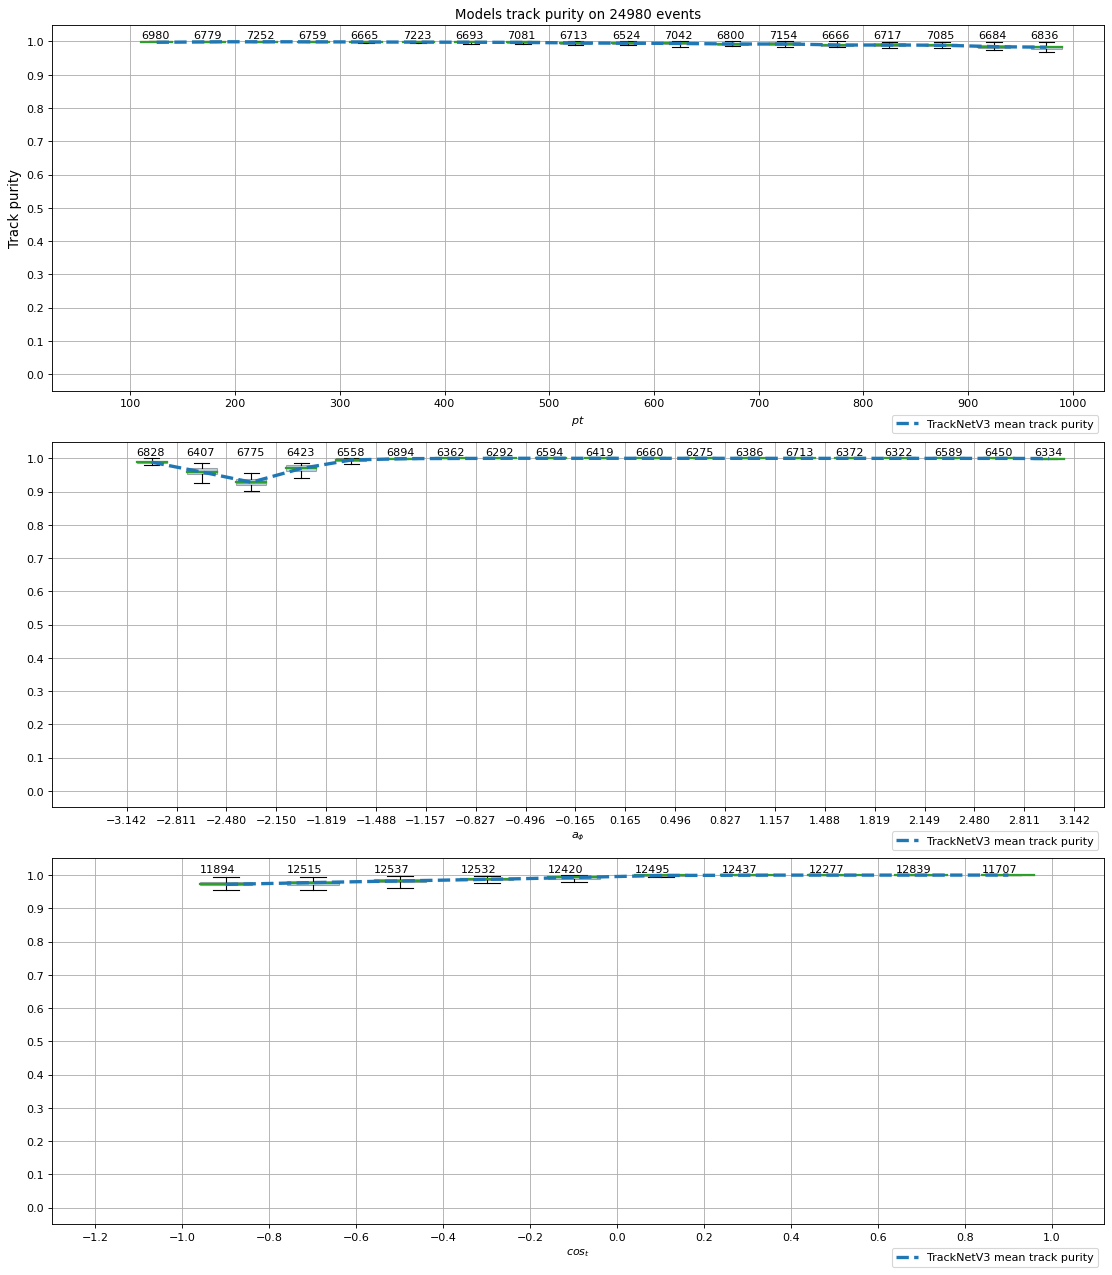

In [50]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_precision)

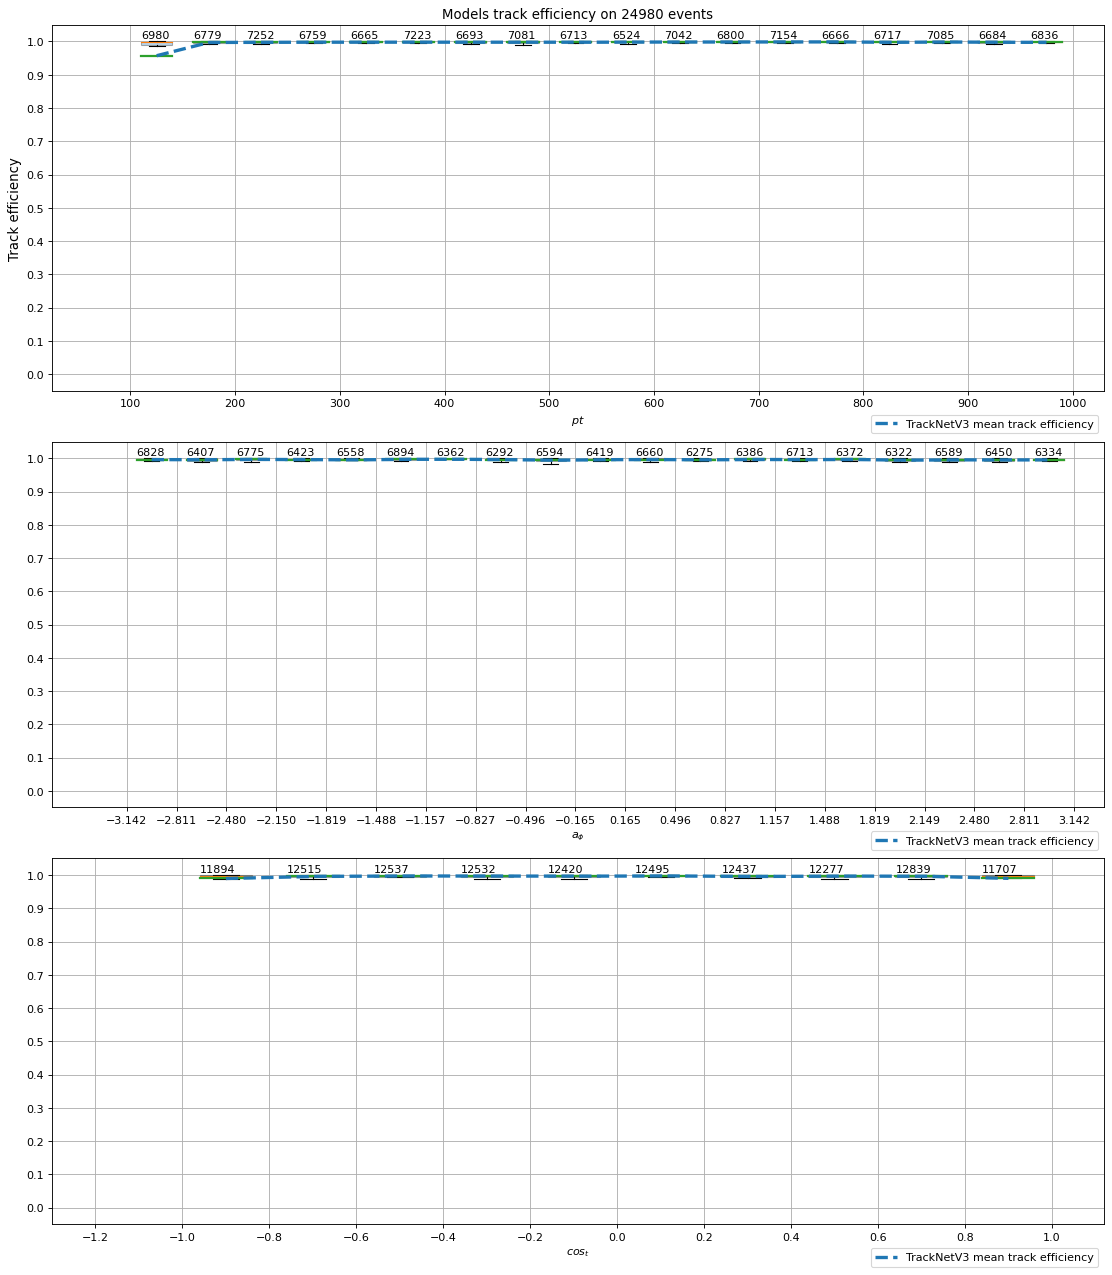

In [51]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_recall)